# Code to generate the vector of the images

## Import libraries

In [1]:
import cv2
import os
import csv
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import argparse
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, linear_model
from skimage.morphology import disk
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
import seaborn as sns
from fractions import Fraction

## Common variables

In [2]:
original_folder = 'data/original'
rustico_folder = 'data/rustico'
test_folder = 'data/test'
process_folder = 'data/process'

if not os.path.exists(test_folder):
    os.makedirs(test_folder)
    
if not os.path.exists(process_folder):
    os.makedirs(process_folder)
    
sections_number  = 100
sections_width  = 100

seed = 45

## Methods

In [3]:
class Line:
    def __init__(self, m, n):
        if (m==0):
            m=1
        self.m = m
        self.n = n
        self.y1 = 0
        self.x1 = int((self.y1 - self.n) /self.m)
        self.y2 = 100
        self.x2 = int((self.y2 - self.n) /self.m)

    def distance(self, x0, y0):
        return abs((self.A*x0+self.B*y0+self.C)/(math.sqrt(self.A**2+self.B**2)))


In [4]:
def potentialImage(img,width,from_section,to_section,number_sections):
    dim_width = int(img.shape[0]/width)
    dim_heigth = int(img.shape[1])
    from_width = dim_width*(max(from_section-number_sections,0))
    to_width = dim_width*(min(to_section+number_sections,width-1))
    return img[from_width:to_width+dim_width,:]

def sections(img, width=1, heigth=1):
    sections_list = []
    dim_width = int(img.shape[0]/width)
    dim_heigth = int(img.shape[1]/heigth)
    total_pixels_section = dim_width*dim_heigth
    for i in range(0,width):
        for j in range(0,heigth):
            pos_width = dim_width*i
            pos_heigth = dim_heigth*j
            img_cut=img[pos_width:pos_width+dim_width,pos_heigth:pos_heigth+dim_heigth]
            sections_list.append((np.count_nonzero(img_cut == 255)*100)/total_pixels_section)
    return sections_list

def potentialSections(section_list):
    selection = []
    for i in range(0,len(section_list)-1):
        diff = abs(section_list[i] - section_list[i+1])
        if(diff>5):
            if(i not in selection):
                selection.append(i)
            selection.append(i+1)

    groups = []
    groups_diff = []
    for i in range(0, len(selection)-1):
        diff = abs(selection[i] - selection[i+1])
        if len(groups)==0 or (diff>5):
            group = []
            groups.append(group)
            group_diff = []
            groups_diff.append(group_diff)
        group = groups[-1]
        if (diff<5) and selection[i] not in group:
            group.append(selection[i])
        group.append(selection[i+1])
        diff_v = abs(section_list[selection[i]] - section_list[selection[i+1]])
        group_diff = groups_diff[-1]
        if (diff<5):
            group_diff.append(diff_v)

    max_value=0
    max_group = 0
    for i in range(0,len(groups_diff)):
        max_v = max(groups_diff[i])
        if max_v>max_value:
            max_value = max_v
            max_group = i
    if len(groups)>0:
        potentialGroup = groups[max_group]
    else:
        potentialGroup = []
    return [selection, potentialGroup]

def polynomial(X,y,degree):
    try:
        reg = linear_model.LinearRegression().fit(X, y)
        line = Line(reg.coef_[0], reg.intercept_)
    except ValueError:
        if y[0] == y[-1]:
            line = Line(1, 0)
        else:
            m = (y[-1]-y[0])/(X[-1]-X[0])
            n = -((X[0]*(y[-1]-y[0]))/(X[-1]-X[0]))+y[0]
            line = Line(m, n)
    return line

In [5]:
def regionOfInterest(img_name, original_img, img, plot =False, disk_size = 67):
    
    #Morphology
    kernel = disk(disk_size)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    #Percentage of white pixels and potential section
    section_list = sections(closing,sections_number)
    selection, potential_sections = potentialSections(section_list)
    if len(potential_sections)>0:
        section_list_np = np.asarray(section_list).astype(np.float)
        potential_section = section_list_np[selection]
        potential_values = section_list_np[potential_sections]
        #Potential image
        img_potential = potentialImage(original_img,sections_number,potential_sections[0],potential_sections[-1],3)
        img_potential_RUSTICO = potentialImage(img,sections_number,potential_sections[0],potential_sections[-1],3)
        cv2.imwrite(os.path.join(process_folder, img_name+'_potential.jpg'),cv2.cvtColor(img_potential, cv2.COLOR_BGR2RGB))
        cv2.imwrite(os.path.join(process_folder, img_name+'_potential.png'),img_potential_RUSTICO)
        
        if plot:
            #Plot process
            f, axs = plt.subplots(1,5,figsize=(20,3))
            axs[0].imshow(original_img)
            axs[0].axis('off')
            axs[0].title.set_text('Original')
            axs[1].imshow(img, cmap='gray')
            axs[1].axis('off')
            axs[1].title.set_text('RUSTICO')
            axs[2].imshow(closing, cmap='gray')
            axs[2].axis('off')
            axs[2].title.set_text('Morphological operations')
            axs[3].plot( range(0,sections_number), section_list, '.')
            axs[3].plot( selection, potential_section, '+')
            axs[3].plot( potential_sections, potential_values, '*')
            axs[3].title.set_text('Study of white pixel percetage')
            axs[3].set_ylabel('White pixel percetage')
            axs[4].imshow(img_potential)
            axs[4].axis('off')
            axs[4].title.set_text('Potential image')
            plt.savefig(os.path.join(process_folder, img_name+'_process.jpg'), dpi=200)
            plt.close('all')
    
        return [img_potential, img_potential_RUSTICO]    
    else:
        return [None, None]

In [6]:
def processRegion(img_name, img_potential, img_potential_RUSTICO, plot=False, kernel_size=(31,79)):
    #Morphology (potential image)
    kernel = np.ones(kernel_size ,np.uint8)
    closing_potential = cv2.dilate(img_potential_RUSTICO,kernel,iterations = 1)

    #Add borders and morhpology
    section_list = sections(closing_potential,10)
    widthMask = closing_potential.shape[1]
    heightMask = closing_potential.shape[0]
    if section_list[0]>0.5:
        mask1 = np.ones((10, widthMask), np.uint8)*255
        mask2 = np.zeros((10, widthMask), np.uint8)
    else:
        mask1 = np.zeros((10, widthMask), np.uint8)
        mask2 = np.ones((10, widthMask), np.uint8)*255
    mask3 = np.ones((heightMask + 20, 10), np.uint8)*255

    closing_mask = np.vstack((mask1, closing_potential))
    closing_mask = np.vstack((closing_mask, mask2))
    closing_mask = np.hstack((mask3, closing_mask))
    closing_mask = np.hstack((closing_mask, mask3))
    closing_mask = cv2.morphologyEx(closing_mask, cv2.MORPH_CLOSE, kernel)
    contours, hierarchy = cv2.findContours(closing_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        added_image = cv2.fillPoly(closing_mask, [cnt], (255))
    closing_mask = closing_mask[10:-10,10:-10]

    #Potential image and mask
    image_mask = cv2.bitwise_not(closing_mask)
    img2 = cv2.merge((image_mask,image_mask,image_mask))
    added_image = cv2.addWeighted(img2,0.1,img_potential,0.4,0)

    #rectangle
    heigths = []
    sections_list = []
    final = []
    for i in range(0,sections_width):
        dim_heigth = int(closing_mask.shape[1]/sections_width)
        closing1 = closing_mask[:, i*dim_heigth:(i+1)*dim_heigth]
        contours, hierarchy = cv2.findContours(closing1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        img2 = cv2.merge((closing1,closing1,closing1))
        if(len(contours)>0):
            cnt = contours[0]
            area_max = 0
            for cn in contours:
                area = cv2.contourArea(cn)
                if area > area_max:
                    area_max = area
                    cnt = cn
            hull = cv2.convexHull(cnt)
            x,y,w,h = cv2.boundingRect(cnt)
            heigths.append(h)
            cut1 = closing1[x:x+w, y:y+h]
            total_pixels_section = w*h
            sections_list.append((np.count_nonzero(cut1 == 255)*100)/total_pixels_section)
            img2 = cv2.drawContours(img2, [cnt], -1, (0,255,0), 2)
            img2 = cv2.rectangle(img2,(x,y),(x+w,y+h),(255,0,0),2)
            if len(final) ==0:
                final = img2.copy()
            else:
                final = np.hstack((final,img2))

    if plot:
        #Plot potential image process
        f, axs = plt.subplots(6,1,figsize=(15,10))
        axs[0].imshow(img_potential)
        axs[0].axis('off')
        axs[0].title.set_text('Original')
        axs[1].imshow(img_potential_RUSTICO, cmap='gray')
        axs[1].axis('off')
        axs[1].title.set_text('RUSTICO')
        axs[2].imshow(closing_potential, cmap='gray')
        axs[2].axis('off')
        axs[2].title.set_text('Morphological operations')
        axs[3].imshow(closing_mask, cmap='gray')
        axs[3].axis('off')
        axs[3].title.set_text('Morphological operations')
        axs[4].imshow(added_image)
        axs[4].axis('off')
        axs[4].title.set_text('Final result')
        axs[5].imshow(final)
        axs[5].axis('off')
        axs[5].title.set_text('Final result')
        plt.savefig(os.path.join(process_folder, img_name+'_potential_process.jpg'), dpi=200)
        plt.close('all')
    
    return  [heigths, sections_list]

# Samples of dataset

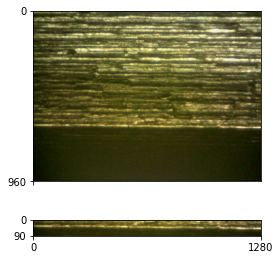

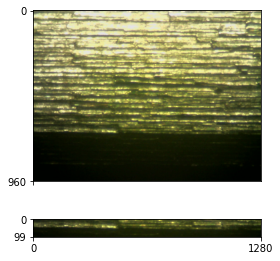

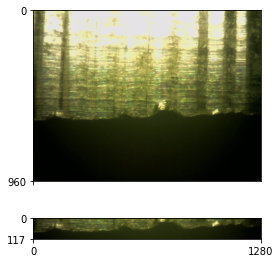

In [7]:
def show_images(image):
    dir = os.path.join(rustico_folder, image)
    img_name = image[:-4]
    folder_pieza = img_name[:8]
    img_pieza = img_name[9:]      
    original_img =  np.array(Image.open(os.path.join(original_folder, folder_pieza+"_"+img_pieza+'.jpg')))
    img = cv2.imread(os.path.join(rustico_folder, image), cv2.IMREAD_GRAYSCALE)
    img_potential, img_potential_RUSTICO = regionOfInterest(img_name, original_img, img)

    fr = Fraction(original_img.shape[0], img_potential.shape[0])
    f, axs = plt.subplots(2,1,figsize=(4,4), gridspec_kw={'height_ratios': [fr.numerator,fr.denominator]}, sharex=True)
    axs[0].imshow(original_img)
    axs[0].set_yticks([0, original_img.shape[0]])
    axs[1].imshow(img_potential)
    axs[1].set_xticks([0, img_potential.shape[1]])
    axs[1].set_yticks([0, img_potential.shape[0]])
    f.tight_layout()
    
image = 'Pieza_01_foto39.png'
show_images(image)
plt.savefig('img_types_k.jpg', dpi=200)
plt.show()

image = 'Pieza_01_foto0137.png'
show_images(image)
plt.savefig('img_types_s.jpg', dpi=200)
plt.show()

image = 'Pieza_03_foto061.png'
show_images(image)
plt.savefig('img_types_b.jpg', dpi=200)
plt.show()

## Grid search to choose the best parameters

In [8]:
images = os.listdir(rustico_folder)
random.Random(seed).shuffle(images)
size_test = int(len(images)/4)
print(str(size_test)+" images for grid search of "+str(len(images))+" images in total")

56 images for grid search of 224 images in total


In [9]:
for disk_size in [47,53,67]:
    for kernel_size in [(79,79), (31,79), (79,31)]:
        csv_file=os.path.join(test_folder, 'info_h_'+str(sections_width)+"_"+str(disk_size)+"_"+str(kernel_size[0])+"_"+str(kernel_size[1])+'.csv')
        data_file = open(csv_file, "w", newline="",encoding="utf-8")
        data_file.close()
        headers = ['img_name','folder','image']  + ['h_'+str(i) for i in range(1,sections_width+1)] + ['pw_'+str(i) for i in range(1,sections_width+1)]
        with open(csv_file, mode='a+', newline="",encoding="utf-8") as data_file:
            data_writer = csv.writer(data_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow(headers)

        for image in images[0:size_test]:
            if image.endswith('.png'):
                dir = os.path.join(rustico_folder, image)
                img_name = image[:-4]
                folder_pieza = img_name[:8]
                img_pieza = img_name[9:]
                #print(img_name)        
                original_img =  np.array(Image.open(os.path.join(original_folder, folder_pieza+"_"+img_pieza+'.jpg')))
                img = cv2.imread(os.path.join(rustico_folder, image), cv2.IMREAD_GRAYSCALE)
                img_potential, img_potential_RUSTICO = regionOfInterest(img_name, original_img, img, disk_size = disk_size)

                
                if img_potential is not None:            
                    heights, sections_list = processRegion(img_name, img_potential, img_potential_RUSTICO, kernel_size=kernel_size)   
                    
                    if len(heights)==sections_width:
                        data_final = [img_name, int(folder_pieza[-2:]), int(img_pieza[4:])] + heights + sections_list
                        with open(csv_file, mode='a+', newline="",encoding="utf-8") as data_file:
                            data_writer = csv.writer(data_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                            data_writer.writerow(data_final)


In [10]:
data_category = pd.read_csv('data/info_category.csv', delimiter=';', decimal=".") 

In [11]:
def prepare_data(file_name, data_category):
    data = pd.read_csv(file_name, delimiter=';', decimal=".") 
    data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
    data[['category']] =  data[['category']]-1
    return data

In [12]:
csv_file=os.path.join(test_folder, 'grid_search.csv')

In [13]:
csv_file=os.path.join(test_folder, 'grid_search.csv')
data_file = open(csv_file, "w", newline="",encoding="utf-8")
data_file.close()
headers = ['file','disk_size','kernel_size1', 'kernel_size2', 'accuracy']
with open(csv_file, mode='a+', newline="",encoding="utf-8") as data_file:
    data_writer = csv.writer(data_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(headers)

for file_name in os.listdir(test_folder):
    if file_name.startswith('info'):
        data = prepare_data(os.path.join(test_folder,file_name), data_category)
        info = file_name[:-4].split("_")
        X_values = data[['h_'+str(a) for a in range(1,int(info[2])+1)]]
        y_values = data[['category']]
        X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

        clf = svm.SVC(random_state=seed)
        clf.fit(X_train, y_train.values.ravel())
        mean_accuracy = clf.score(X_test, y_test.values.ravel())

        data_final = [file_name, info[3], info[4], info[5], mean_accuracy]
        with open(csv_file, mode='a+', newline="",encoding="utf-8") as data_file:
            data_writer = csv.writer(data_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow(data_final)

In [14]:
data_grid = pd.read_csv(csv_file, delimiter=';', decimal=".") 
matrix = []

for disk_size in [47,53,67]:
    row = []
    matrix.append(row)
    for kernel_size in [(79,79), (31,79), (79,31)]:
        index = np.where((data_grid['disk_size'] == disk_size) & (data_grid['kernel_size1'] == kernel_size[0]) & (data_grid['kernel_size2'] == kernel_size[1]))[0][0]        
        row.append(data_grid.iloc[index]['accuracy'])

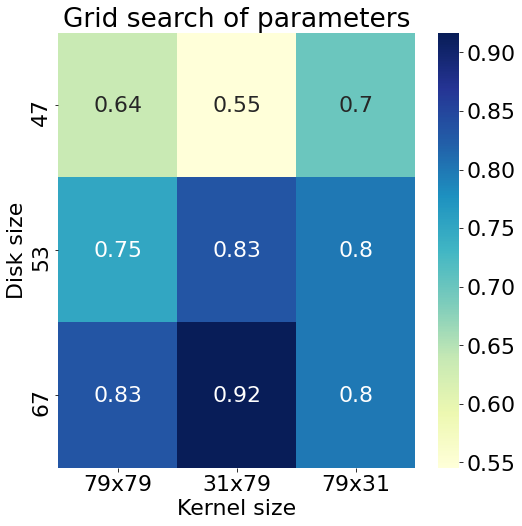

In [15]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(matrix, cmap="YlGnBu", yticklabels=[47,53,67], xticklabels=['79x79','31x79', '79x31'], annot=True, fmt=".2")

plt.title('Grid search of parameters') 
plt.ylabel('Disk size') 
plt.xlabel('Kernel size') 

plt.savefig('grid_search_parameters.jpg', dpi=200)
plt.show()

## Generate vector

In [16]:
disk_size = 67
kernel_size1= 31
kernel_size2 = 79

In [17]:
#sections_number = 100
for sections_width in range(10,110,10):
    csv_file='data/info_h_'+str(sections_width)+'.csv'
    data_file = open(csv_file, "w", newline="",encoding="utf-8")
    data_file.close()
    headers = ['img_name','folder','image']  + ['h_'+str(i) for i in range(1,sections_width+1)] + ['pw_'+str(i) for i in range(1,sections_width+1)]
    with open(csv_file, mode='a+', newline="",encoding="utf-8") as data_file:
        data_writer = csv.writer(data_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        data_writer.writerow(headers)
        
    for image in os.listdir(rustico_folder):
        if image.endswith('.png'):
            dir = os.path.join(rustico_folder, image)
            img_name = image[:-4]
            folder_pieza = img_name[:8]
            img_pieza = img_name[9:]
            #print(img_name)        
            original_img =  np.array(Image.open(os.path.join(original_folder, folder_pieza+"_"+img_pieza+'.jpg')))
            img = cv2.imread(os.path.join(rustico_folder, image), cv2.IMREAD_GRAYSCALE)
            img_potential, img_potential_RUSTICO = regionOfInterest(img_name, original_img, img, disk_size = disk_size)

            if img_potential is not None:            
                heights, sections_list = processRegion(img_name, img_potential, img_potential_RUSTICO, kernel_size=(kernel_size1,kernel_size2))   

                if len(heights)==sections_width:
                    data_final = [img_name, int(folder_pieza[-2:]), int(img_pieza[4:])] + heights + sections_list
                    with open(csv_file, mode='a+', newline="",encoding="utf-8") as data_file:
                        data_writer = csv.writer(data_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        data_writer.writerow(data_final)